<a href="https://colab.research.google.com/github/L120Git/NLP_Google_Restaurants/blob/main/1_NLP_carga_y_analisis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##0.Librerías necesarias

In [1]:
#!pip install rarfile
#!pip install unzip
!pip install pandas
!pip install numpy
!pip install stop-words
!pip install num2words


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
#Librerias necesarias
import numpy as np
import pandas as pd
from google.colab import drive
import random
#import rarfile # para descomprimir archivos
import json
#import csv 
#para limpiar los datos
import nltk
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk import RegexpTokenizer
from nltk.stem import WordNetLemmatizer 
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('punkt')
from nltk.tokenize import sent_tokenize
nltk.download('omw-1.4')
import string
import unicodedata
from num2words import num2words
#para reducir la dimensión
from sklearn.manifold import TSNE
#para representar
import matplotlib.pyplot as plt

#análisis exloratorio
from collections import Counter
from nltk import ngrams
from nltk.probability import FreqDist
from wordcloud import WordCloud
from nltk.probability import FreqDist

#preprocesado
from stop_words import get_stop_words
import unicodedata
import re

#modelado
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#reporte
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, precision_recall_curve


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


##1. Carga de datos

In [4]:
# Montamos GDrive para almacenar los datos
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!pwd

/content


In [6]:
#with rarfile.RarFile('/content/drive/MyDrive/NLP/filter_all_t.json', 'r') as rf:
#  rf.extractall('./content')

In [7]:
#Localizamos el archivo y lo leemos
path = '/content/drive/MyDrive/NLP/'

with open(f'{path}filter_all_t.json', 'r') as f:
  data = json.load(f)

data = data['train']#[10000]  #subset de las primeras 10000 líneas
data

[{'business_id': '60567465d335d0abfb415b26',
  'user_id': '101074926318992653684',
  'rating': 4,
  'review_text': 'The tang of the tomato sauce is outstanding. And the crust is a meal, as it should be. Order a whole pie fresh.',
  'pics': ['AF1QipM-2IRmvitARbcJr7deWfe5hyVBg_ArPMQSYvq0',
   'AF1QipPWhe1OP80YPU40J6-XIdxbJIe57vKm8TTjve31',
   'AF1QipNuKWM65S9ZFQykvdIhKUliE6K1VBxssTUYyl8d',
   'AF1QipOJng1JS_1hmpfhAVrr7hE89dcoOtdy-Z6cOO9x'],
  'history_reviews': [['101074926318992653684_6056272797d555cc6fb0d147',
    'The pizza here is the real deal, perfect in every way except for the crust, which was more cracker crisp than chewy bread. Also recommend the meatball parmigiana hero, beefy, fluffy, overflowing, tangy, chunky tomato sauce, toothsome bread.'],
   ['101074926318992653684_604a65c2c6dc737bce7e5a3d',
    'Omg the tomato sauce is everything, in the meatball appetizer, pizza & as a dip for that scratch-made focaccia. Farm-fresh salad. A variety of artisan toppings. Ask for the chi

In [8]:
#Creamos el df 
reviews_text = []
reviews_sentiment = []

for review in data:
    reviews_text.append(review.get('review_text'))
    reviews_sentiment.append(review.get('rating'))

df= pd.DataFrame({
    'review_text': reviews_text,
    'reviews_sentiment': reviews_sentiment
})
df.dropna(subset=['review_text', 'reviews_sentiment'], inplace=True)
df.reset_index(drop=True, inplace=True)
df

,review_text,reviews_sentiment
0,The tang of the tomato sauce is outstanding. A...,4
1,Chicken and waffles were really good!,5
2,The appetizer of colossal shrimp was very good...,4
3,The fish tacos here omg! The salad was great ...,5
4,"Ribs are great, as are the mac and cheese, fri...",4
...,...,...
87008,The tacos were just okay.,3
87009,I had the Pasta Mardi Gras,5
87010,We order the Pork Bar-B-Que pizza (our favorit...,4
87011,"Beer was very tasty, The Alt was one of my fav...",5


In [9]:
#observo la cantidad de ratings distintos que hay para ver si debo hacer un balance
print(Counter(df['reviews_sentiment'].tolist())) 

Counter({5: 54665, 4: 22333, 3: 6918, 2: 2027, 1: 1070})


In [10]:
#creo una función que me estrae de forma aleatoria un porcentaje de muestras positivas y negativas

rows_pos = 0.05 #elijo el porcentaje de datos positivos que voy a extraer 
rows_neg = 0.35 #datos negativos

def Balance(df):
  ''' 
  df: dataframe a balancear
  '''
  #defino las muestras negativas que me quiero quedar
  df_positive= df[df['reviews_sentiment']>= 4].sample(frac = rows_pos, replace=True) 
  
  #defino las muestras positivas que me quiero quedar
  df_negative = df[df['reviews_sentiment']<=3].sample(frac= rows_neg, replace=True)

  #concateno todo, y añado los negativos a mi df
  df_balanced = pd.concat([df_positive, df_negative]).sample(frac=1).reset_index(drop=True)

  #reseteo los índices
  #df_balanced.reset_index(drop=True, inplace=True)

  return df_balanced

df_balanced = Balance(df)
df_balanced


,review_text,reviews_sentiment
0,We had the fried pimento cheese fritters which...,5
1,This was te worst pizza I have ever tasted. I ...,1
2,Most amazing tacos!!,5
3,Highly recommend the French fries with the mus...,5
4,Good selection of proteins.,4
...,...,...
7350,This was my first time trying Joe's Pizza Napo...,5
7351,"I got Carla's Combo Sampler with onion rings, ...",5
7352,Staff was friendly atmosphere was nice the fil...,2
7353,I highly recommend the short ribs which truly ...,5


In [11]:
#observo la cantidad de ratings distintos que hay para ver el balance
print(Counter(df_balanced['reviews_sentiment'].tolist())) 

Counter({5: 2719, 3: 2453, 4: 1131, 2: 709, 1: 343})


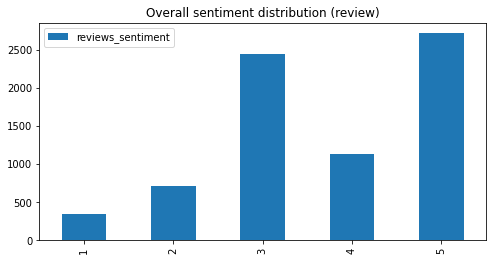

In [12]:
#mostramos la gráfica para ver como se distribuyen los ratings
aux_df = pd.DataFrame(df_balanced['reviews_sentiment'].value_counts(sort=False).sort_index()) #creo un df solo con los ratings
aux_df = aux_df.plot(kind='bar', title='Overall sentiment distribution (review)', figsize=(8, 4)) #lo ploteo

In [13]:
#split en train y test de del df_data
train, test = train_test_split(df_balanced, test_size = 0.25)

print("Ejemplos usados para entrenar: ", len(train))
print("Ejemplos usados para test: ", len(test))

Ejemplos usados para entrenar:  5516
Ejemplos usados para test:  1839


##2. Análisis exploratorio

### 2.1. Primero el análisis del conjunto de entrenamiento

In [14]:
train

,review_text,reviews_sentiment
4686,I did notice the noodles were dry like they ha...,3
3044,"The seafood was okay, but overall lacking flav...",2
7268,Great nigiri - giant cuts of fish!,4
2054,My sister always gets the chicken salad croiss...,5
2031,I've had donuts off their truck on more than o...,5
...,...,...
1943,Lots of different dipping sauces; great Happy ...,4
540,Great street tacos with cilantro and cheese on...,5
2824,"Delicious, large pizzas, with great variety an...",5
5436,Food: Pork carnitas were tender and well seaso...,4


In [15]:
#convertimos en minúsculas y tokenizamos por espacios 
reviews = train['review_text'].str.lower().str.split() 
train.head()

,review_text,reviews_sentiment
4686,I did notice the noodles were dry like they ha...,3
3044,"The seafood was okay, but overall lacking flav...",2
7268,Great nigiri - giant cuts of fish!,4
2054,My sister always gets the chicken salad croiss...,5
2031,I've had donuts off their truck on more than o...,5


#### 2.1.1. Cardinalidad del vocabulario

In [16]:
def word_count(text):
    # Tokenizar el texto
    tokens = nltk.word_tokenize(text)
    # Eliminar las palabras vacías
    tokens = [word for word in tokens if word not in stopwords.words('spanish')]
    return tokens

In [17]:
train['words'] = train['review_text'].apply(word_count)
train.head()

,review_text,reviews_sentiment,words
4686,I did notice the noodles were dry like they ha...,3,"[I, did, notice, the, noodles, were, dry, like..."
3044,"The seafood was okay, but overall lacking flav...",2,"[The, seafood, was, okay, ,, but, overall, lac..."
7268,Great nigiri - giant cuts of fish!,4,"[Great, nigiri, -, giant, cuts, of, fish, !]"
2054,My sister always gets the chicken salad croiss...,5,"[My, sister, always, gets, the, chicken, salad..."
2031,I've had donuts off their truck on more than o...,5,"[I, 've, had, donuts, off, their, truck, on, m..."


In [18]:
#creamos una lista con la suma de las palabras de todas las reviews
words = list(train['words'].sum())
words

['I',
 'did',
 'notice',
 'the',
 'noodles',
 'were',
 'dry',
 'like',
 'they',
 'had',
 'been',
 'sitting',
 'for',
 'awhile',
 '.',
 'The',
 'seafood',
 'was',
 'okay',
 ',',
 'but',
 'overall',
 'lacking',
 'flavor',
 'and',
 'underwhelming',
 '.',
 'Great',
 'nigiri',
 '-',
 'giant',
 'cuts',
 'of',
 'fish',
 '!',
 'My',
 'sister',
 'always',
 'gets',
 'the',
 'chicken',
 'salad',
 'croissant',
 'and',
 'says',
 'it',
 "'s",
 'really',
 'good',
 '.',
 'I',
 "'ve",
 'had',
 'donuts',
 'off',
 'their',
 'truck',
 'on',
 'more',
 'than',
 'one',
 'occasion',
 ',',
 'my',
 'standard',
 'go-to',
 'is',
 'their',
 'chocolate',
 'frosted-glazed',
 'donut',
 '.',
 'However',
 ',',
 'this',
 'was',
 'my',
 'first',
 'time',
 'snagging',
 'multiple',
 'donuts',
 'from',
 'these',
 'guys',
 ',',
 'and',
 'with',
 'it',
 'being',
 'the',
 'beginning',
 'of',
 'Labor',
 'Day',
 'weekend',
 'my',
 'better',
 'judgment',
 'lead',
 'here',
 '.',
 'I',
 'was',
 'able',
 'to',
 'snag',
 'half',
 'do

In [19]:
#visualizamos las palabras sin duplicados
unique_word= list(set(train['words'].sum()))
unique_word

['WRONG',
 'fishy',
 'Specifically',
 'PizzaExpert',
 'Fiance',
 'buff',
 'huge',
 '5.',
 'basics',
 'IHOP',
 'kinda',
 'healthy',
 'possible',
 'Shell',
 'hard',
 'half-hearted',
 'charts',
 'TLDR',
 'politely',
 'reason',
 'hey',
 '7.99',
 'Big',
 'connection',
 'Chargrilled',
 'Me',
 'skewer',
 '10/10',
 'annoyed',
 'remains',
 'send',
 'delivers',
 'beach',
 'Buttercream',
 'croque-monsieur',
 'smoky',
 'encased',
 'Tempura',
 'upon',
 'shelled',
 '19.95',
 'non-pastry',
 'planned',
 'Pollo',
 'iced',
 'wife',
 'Tip',
 'Smokey',
 'earthy',
 'munch',
 'skillet',
 'WARRENS',
 'advertising',
 'pub',
 'Plate',
 'Both',
 'touxh',
 'Signature',
 'featuring',
 'issue',
 'softshell',
 'shared',
 'new',
 'trust',
 'intestines',
 '4',
 'Road',
 'brodo',
 'rye',
 'cousin',
 'Pies',
 'award',
 'Palmer',
 'ginormous',
 'Hair',
 'Award',
 'presentation',
 'commercial',
 'incrusted',
 'med',
 'sink',
 'addictive',
 'bottled',
 'joke.',
 'cloyingly',
 'LETTUCE',
 'imperial',
 'stockman',
 'rated',

In [20]:
total_words = len(words)
total_words

167261

In [21]:
total_unique_words = len(unique_word)
total_unique_words

10265

#### 2.1.2. Análisis de sentimiento

In [22]:
#analizo el sentimiento en el punto medio 
train[train['reviews_sentiment']== 3]

,review_text,reviews_sentiment,words
4686,I did notice the noodles were dry like they ha...,3,"[I, did, notice, the, noodles, were, dry, like..."
7247,"But, the chicken sandwich I got may have been ...",3,"[But, ,, the, chicken, sandwich, I, got, may, ..."
1640,"As for the food...eh, so I had the curry chick...",3,"[As, for, the, food, ..., eh, ,, so, I, had, t..."
2811,Only 4 pieces were in Seared tuna salad. Calam...,3,"[Only, 4, pieces, were, in, Seared, tuna, sala..."
6175,"The sandwich is full of pulled pork, wish ther...",3,"[The, sandwich, is, full, of, pulled, pork, ,,..."
...,...,...,...
6502,The po boy was more bread than shrimp but what...,3,"[The, po, boy, was, more, bread, than, shrimp,..."
6495,11-10-19 - Decided to take my daughter for som...,3,"[11-10-19, -, Decided, to, take, my, daughter,..."
2668,I got the rib combo with brisket. The brisket ...,3,"[I, got, the, rib, combo, with, brisket, ., Th..."
6421,I ordered a chicken burrito plate which consis...,3,"[I, ordered, chicken, burrito, plate, which, c..."


In [23]:
#definimos una etiqueta de sentimiento 0 para los negativos, 1 para los positivos
def label_sentiment(row):
    if int(row['reviews_sentiment']) >= 4: # 4 o más ratings es positivo
        return 1
    else:
        return 0 #el resto negativos

In [24]:
#aplico las etiquetas y las meto en una columna
train['sentiment_label'] = train.apply(lambda row: label_sentiment(row), axis=1)

In [25]:
train.head()

,review_text,reviews_sentiment,words,sentiment_label
4686,I did notice the noodles were dry like they ha...,3,"[I, did, notice, the, noodles, were, dry, like...",0
3044,"The seafood was okay, but overall lacking flav...",2,"[The, seafood, was, okay, ,, but, overall, lac...",0
7268,Great nigiri - giant cuts of fish!,4,"[Great, nigiri, -, giant, cuts, of, fish, !]",1
2054,My sister always gets the chicken salad croiss...,5,"[My, sister, always, gets, the, chicken, salad...",1
2031,I've had donuts off their truck on more than o...,5,"[I, 've, had, donuts, off, their, truck, on, m...",1


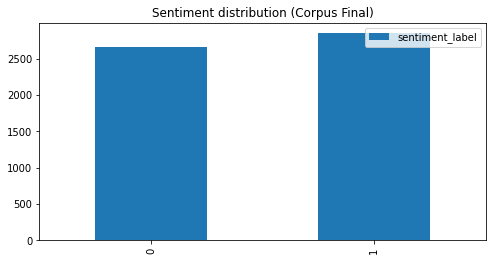

In [26]:
aux_df = pd.DataFrame(train['sentiment_label'].value_counts(sort=False).sort_index())
aux_df = aux_df.plot(kind='bar', title='Sentiment distribution (Corpus Final)', figsize=(8, 4))

In [27]:
#contamos las reviews positivas y las negativas
print('Total de etiquetas negativas: ', len(train[train['sentiment_label']== 0]))
print('Total de etiquetas positivas: ',len(train[train['sentiment_label']== 1]))


Total de etiquetas negativas:  2665
Total de etiquetas positivas:  2851


####2.1.3. N-grams más frecuentes

In [28]:
bigrams_ = ngrams(unique_word, 2)
trigrams_ = ngrams(unique_word, 3)

In [29]:
bigrams_freq_ = FreqDist(bigrams_)
trigrams_freq_ = FreqDist(trigrams_)

In [30]:
bigrams_freq_.most_common(10)

[(('WRONG', 'fishy'), 1),
 (('fishy', 'Specifically'), 1),
 (('Specifically', 'PizzaExpert'), 1),
 (('PizzaExpert', 'Fiance'), 1),
 (('Fiance', 'buff'), 1),
 (('buff', 'huge'), 1),
 (('huge', '5.'), 1),
 (('5.', 'basics'), 1),
 (('basics', 'IHOP'), 1),
 (('IHOP', 'kinda'), 1)]

In [31]:
trigrams_freq_.most_common(10)


[(('WRONG', 'fishy', 'Specifically'), 1),
 (('fishy', 'Specifically', 'PizzaExpert'), 1),
 (('Specifically', 'PizzaExpert', 'Fiance'), 1),
 (('PizzaExpert', 'Fiance', 'buff'), 1),
 (('Fiance', 'buff', 'huge'), 1),
 (('buff', 'huge', '5.'), 1),
 (('huge', '5.', 'basics'), 1),
 (('5.', 'basics', 'IHOP'), 1),
 (('basics', 'IHOP', 'kinda'), 1),
 (('IHOP', 'kinda', 'healthy'), 1)]

In [32]:
bg_freq_most_common_tr = bigrams_freq_.most_common(10)
bgs_tr = [str(bg[0]) for bg in bg_freq_most_common_tr]
bgs_f_tr = [bg[1] for bg in bg_freq_most_common_tr]

tg_freq_most_common_tr = trigrams_freq_.most_common(10)
tgs_tr = [str(tg[0]) for tg in tg_freq_most_common_tr]
tgs_f_tr = [tg[1] for tg in tg_freq_most_common_tr]

In [33]:
bgs_f_, bgs_ = zip(*sorted(zip(bgs_f_tr, bgs_tr)))
tgs_f_, tgs_ = zip(*sorted(zip(tgs_f_tr, tgs_tr)))

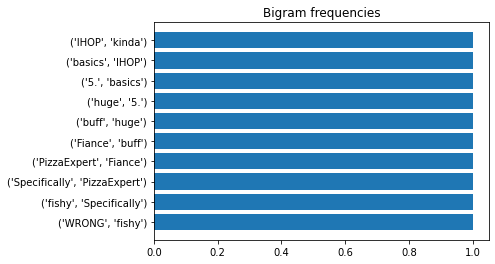

In [34]:
plt.barh(bgs_tr, bgs_f_tr)
plt.title('Bigram frequencies')
plt.show()

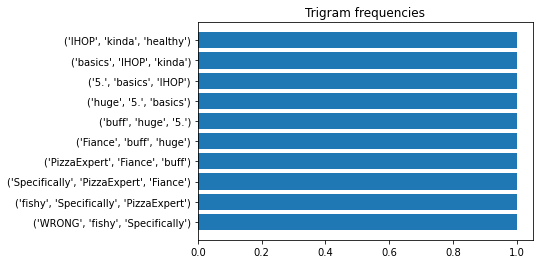

In [35]:
plt.barh(tgs_tr, tgs_f_tr)
plt.title('Trigram frequencies')
plt.show()

####2.1.4. Nube de palabras

In [36]:
#convertir mi lista de palabras en una cadena 
#" ".join(unique_word)

In [37]:
#nube de palabras
def plot_word_cloud(text):
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(" ".join(text))
    plt.figure(figsize=(12,6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

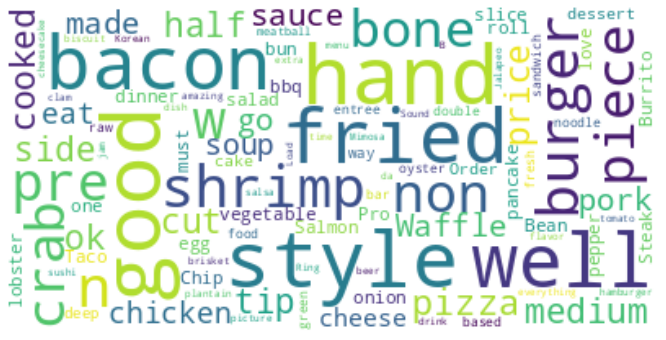

In [38]:
plot_word_cloud(unique_word)

####2.1.5. palabras similares con word2vec

In [39]:
import multiprocessing

from gensim.models import Word2Vec

cores = multiprocessing.cpu_count() # Contamos el número de cores en el ordenador
print (cores)

#hiperparámetros de inicialización 
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)



2


In [40]:
sent = [row for row in train['words']]
w2v_model.build_vocab(sent, progress_per=10000)

In [41]:
print('Vocabulario compuesto por {} palabras'.format(len(w2v_model.wv.vocab)))

Vocabulario compuesto por 936 palabras


In [42]:
#entrenamos el modelo del w2v
w2v_model.train(sent, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

(978955, 5017830)

In [43]:
#algunos resultados similares de sentimiento postivo
w2v_model.wv.most_similar(positive=["fresh"])

[('super', 0.997713565826416),
 ('extremely', 0.9974285364151001),
 ('greasy', 0.9973089098930359),
 ('salty', 0.9971700310707092),
 ('soggy', 0.9971171021461487),
 ('.', 0.996841311454773),
 ('lots', 0.9967104196548462),
 ('heavy', 0.9967094659805298),
 ('ok.', 0.9966317415237427),
 ('breading', 0.9966139793395996)]

In [44]:
#algunos resultados similares de sentimiento postivo
w2v_model.wv.most_similar(positive=["crispy"])

[('crisp', 0.9988695383071899),
 ('juicy', 0.9984238147735596),
 ('crunchy', 0.9980343580245972),
 ('breast', 0.9980155229568481),
 ('flavorful', 0.9977031946182251),
 ('bland', 0.997523307800293),
 ('red', 0.9974849224090576),
 ('tender', 0.997450053691864),
 ('dressing', 0.9973908066749573),
 ('dipping', 0.9969704151153564)]

In [45]:
#algunos resultados similares de sentimiento postivo
w2v_model.wv.most_similar(positive=["chicken"])

[('and', 0.9952077865600586),
 ('slaw', 0.993332028388977),
 ('rice', 0.993133544921875),
 ('mac', 0.9930177927017212),
 ('cheese', 0.9923974275588989),
 ('okra', 0.9923347234725952),
 ('beans', 0.9921501874923706),
 ('shrimp', 0.9906993508338928),
 ('potato', 0.9904223680496216),
 ('fried', 0.9903756380081177)]

In [46]:
w2v_model.wv.similarity('fresh', 'crispy')

0.9855259

In [47]:
w2v_model.wv.similarity('chicken', 'fries')

0.9845092

In [48]:
w2v_model.save('./w2v_model.pkl')

In [49]:
# almacenamos las imagenes en nuestro drive
!cp w2v_model.pkl /content/drive/MyDrive/NLP/w2v_model.pkl


In [50]:
!ls -lah 

total 9.4M
drwxr-xr-x 1 root root 4.0K Mar 12 13:35 .
drwxr-xr-x 1 root root 4.0K Mar 12 09:33 ..
drwxr-xr-x 4 root root 4.0K Mar  9 18:57 .config
drwx------ 5 root root 4.0K Mar 12 13:35 drive
drwxr-xr-x 1 root root 4.0K Mar  9 18:58 sample_data
-rw-r--r-- 1 root root 711K Mar 12 17:48 test.csv
-rw-r--r-- 1 root root 2.2M Mar 12 17:48 train.csv
-rw-r--r-- 1 root root 3.3M Mar 12 18:31 w2v_model.pkl
-rw-r--r-- 1 root root 3.3M Mar 12 17:48 w2v_model_ts.pkl


In [51]:
#cargamos el modelo 
w2v_sg = Word2Vec.load('./w2v_model.pkl')

In [52]:
keys = ['crispy','salad','pulled']

embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in w2v_sg.wv.most_similar(word, topn=10):
        words.append(similar_word)
        embeddings.append(w2v_sg.wv[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

In [53]:
print(word_clusters)

[['crisp', 'juicy', 'crunchy', 'breast', 'flavorful', 'bland', 'red', 'tender', 'dressing', 'dipping'], ['grilled', 'roasted', 'okra', 'sausage', 'dip', 'catfish', '&', 'Shrimp', 'soup', 'slaw'], ['belly', 'greens', 'brisket', 'beans', 'mac', 'roasted', 'slaw', 'okra', 'sausage', 'rice']]


In [54]:
#reducimos la dimensionalidad para representarlo en 2D
tsne_model_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)

embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape

embeddings_2d = np.array(tsne_model_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

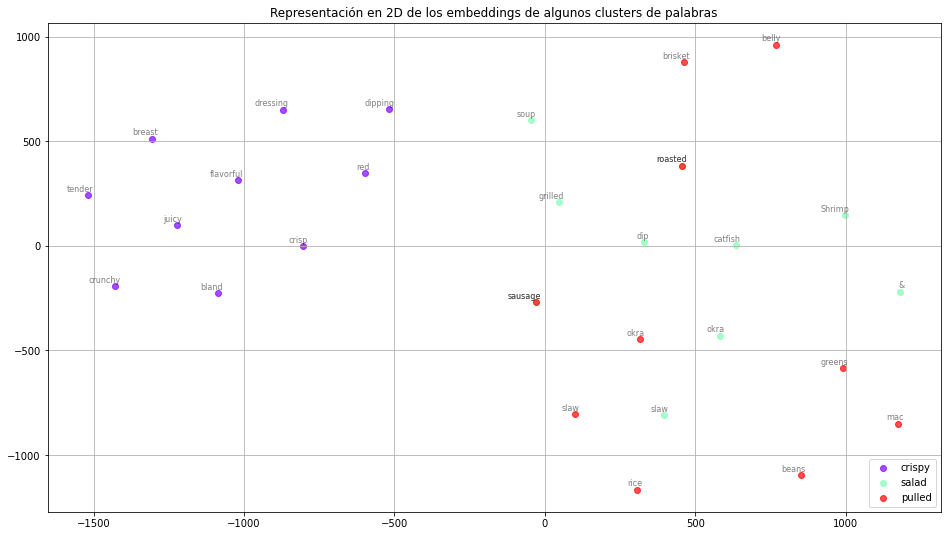

In [55]:
#Representamos los cl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
%matplotlib inline


def tsne_plot_similar_words(labels, embedding_clusters, word_clusters, a=0.7):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:,0]
        y = embeddings[:,1]
        plt.scatter(x, y, c=[color], alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2), 
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.grid(True)
    plt.title('Representación en 2D de los embeddings de algunos clusters de palabras')
    # plt.savefig("f/г.png", format='png', dpi=150, bbox_inches='tight')
    plt.show()


tsne_plot_similar_words(keys, embeddings_2d, word_clusters)

### 2.2. Ahora el mismo análisis para conjunto test

In [56]:
test

,review_text,reviews_sentiment
1173,The chicken is really crispy. Le poulet est vr...,4
3401,This Mexican joint is average nothing special ...,3
3551,Pocahontas Pancakes is located at the Virginia...,3
2825,"Not only was the woman on the speaker, pushy a...",1
7125,"Grilled chicken, black beans and rice.",4
...,...,...
7156,The fries were good but the bowl mine came in ...,3
1417,I found the portions small for the price point...,5
5172,"This time they had bloody Mary, also ordered ...",2
4108,"The first time we had their beignets, we thoug...",2


In [57]:
#convertimos en minúsculas y tokenizamos por espacios 
reviews = train['review_text'].str.lower().str.split() 
train.head()

,review_text,reviews_sentiment,words,sentiment_label
4686,I did notice the noodles were dry like they ha...,3,"[I, did, notice, the, noodles, were, dry, like...",0
3044,"The seafood was okay, but overall lacking flav...",2,"[The, seafood, was, okay, ,, but, overall, lac...",0
7268,Great nigiri - giant cuts of fish!,4,"[Great, nigiri, -, giant, cuts, of, fish, !]",1
2054,My sister always gets the chicken salad croiss...,5,"[My, sister, always, gets, the, chicken, salad...",1
2031,I've had donuts off their truck on more than o...,5,"[I, 've, had, donuts, off, their, truck, on, m...",1


#### 2.1.1. Cardinalidad del vocabulario

In [58]:
#llamamos a nuestra función word_count
test['words'] = test['review_text'].apply(word_count)
test.head()

,review_text,reviews_sentiment,words
1173,The chicken is really crispy. Le poulet est vr...,4,"[The, chicken, is, really, crispy, ., Le, poul..."
3401,This Mexican joint is average nothing special ...,3,"[This, Mexican, joint, is, average, nothing, s..."
3551,Pocahontas Pancakes is located at the Virginia...,3,"[Pocahontas, Pancakes, is, located, at, the, V..."
2825,"Not only was the woman on the speaker, pushy a...",1,"[Not, only, was, the, woman, on, the, speaker,..."
7125,"Grilled chicken, black beans and rice.",4,"[Grilled, chicken, ,, black, beans, and, rice, .]"


In [59]:
#creamos una lista con la suma de las palabras de todas las reviews
words_ts = list(test['words'].sum())
words_ts

['The',
 'chicken',
 'is',
 'really',
 'crispy',
 '.',
 'Le',
 'poulet',
 'est',
 'vraiment',
 'croustillant',
 '.',
 'This',
 'Mexican',
 'joint',
 'is',
 'average',
 'nothing',
 'special',
 'about',
 'except',
 'the',
 'puffy',
 'taco',
 'they',
 'serve',
 '.',
 'I',
 'order',
 '3',
 'puffy',
 'tacos',
 ':',
 '1',
 'beef',
 ',',
 '1',
 'beef',
 'fajita',
 ',',
 'and',
 '1',
 'avocado',
 '.',
 'The',
 'beef',
 'fajita',
 'lacked',
 'flavor',
 ',',
 'the',
 'avocado',
 'was',
 'avocado',
 'so',
 'nothing',
 'to',
 'say',
 'further',
 '.',
 'The',
 'beef',
 'puffy',
 'taco',
 'was',
 'surprisingly',
 'full',
 'of',
 'flavor',
 'so',
 'that',
 'was',
 'the',
 'only',
 'taco',
 'that',
 'stand',
 'out',
 'from',
 'the',
 'rest',
 '.',
 'I',
 'would',
 'only',
 'recommend',
 'this',
 'place',
 'for',
 'the',
 'ones',
 'that',
 'havent',
 'tried',
 'the',
 'puffy',
 'tacos',
 'just',
 'to',
 'try',
 'them',
 '.',
 'Pocahontas',
 'Pancakes',
 'is',
 'located',
 'at',
 'the',
 'Virginia',
 'B

In [60]:
#visualizamos las palabras sin duplicados
unique_word_ts= list(set(test['words'].sum()))
unique_word_ts

['fishy',
 'PizzaExpert',
 'porm',
 'cove',
 'huge',
 'basics',
 'cuttlefish',
 'IHOP',
 'kinda',
 'healthy',
 'possible',
 'Shell',
 'hard',
 'charts',
 'reason',
 '7.99',
 'Big',
 'Krust',
 'Me',
 'skewer',
 '10/10',
 'annoyed',
 'send',
 'delivers',
 'smoky',
 'basting',
 'encased',
 'Tempura',
 'upon',
 'shelled',
 'soi',
 'Pollo',
 'iced',
 'wife',
 'Tip',
 'skillet',
 'Both',
 'Plate',
 'featuring',
 'issue',
 'shared',
 'new',
 'trust',
 '4',
 'rye',
 'Barn',
 'Circus',
 'ginormous',
 'presentation',
 'afterall',
 'closing',
 'cloyingly',
 'patatas',
 'rated',
 'prepping',
 'hours',
 'awards',
 'Offering',
 'What',
 'selections',
 'that',
 'moon',
 'varieties',
 'chopped',
 'barely',
 'KG',
 'pescada',
 '51/60',
 'products',
 'Deep',
 'Margherita',
 'Worse',
 'i',
 'promptly',
 'downtown',
 'peach',
 'kudos',
 'afterlife',
 'jukebox',
 'sweet',
 'Trio',
 'Set',
 'wheat',
 'lechon',
 'bueno',
 'alfredo',
 'dates',
 'Super',
 'memorable',
 'CHOSE',
 'demasiada',
 'moist',
 'differ

In [61]:
total_words_ts = len(words_ts)
total_words_ts

56636

In [62]:
total_unique_words_ts = len(unique_word_ts)
total_unique_words_ts

5850

#### 2.1.2. Análisis de sentimiento

In [63]:
#analizo el sentimiento en el punto medio 
test[test['reviews_sentiment']== 3]

,review_text,reviews_sentiment,words
3401,This Mexican joint is average nothing special ...,3,"[This, Mexican, joint, is, average, nothing, s..."
3551,Pocahontas Pancakes is located at the Virginia...,3,"[Pocahontas, Pancakes, is, located, at, the, V..."
5439,The garlic option is fresh and delicious while...,3,"[The, garlic, option, is, fresh, and, deliciou..."
4052,"Is the stone crab good? Calamari wasnt good, t...",3,"[Is, the, stone, crab, good, ?, Calamari, wasn..."
5365,We had lobster and shrimp ravioli and that tas...,3,"[We, had, lobster, and, shrimp, ravioli, and, ..."
...,...,...,...
2666,"Kale Quinoa Salad with Shrimp. I like kale, I ...",3,"[Kale, Quinoa, Salad, with, Shrimp, ., I, like..."
6340,The sushi was okay. A few of the sushi was kin...,3,"[The, sushi, was, okay, ., A, few, of, the, su..."
2799,"We ordered the banana bread, blueberry pancake...",3,"[We, ordered, the, banana, bread, ,, blueberry..."
1953,I ordered the hot pastrami on rye with the gum...,3,"[I, ordered, the, hot, pastrami, on, rye, with..."


In [64]:
#aplico las etiquetas de sentimiento y las meto en una columna
test['sentiment_label'] = test.apply(lambda row: label_sentiment(row), axis=1)

In [65]:
test.head()

,review_text,reviews_sentiment,words,sentiment_label
1173,The chicken is really crispy. Le poulet est vr...,4,"[The, chicken, is, really, crispy, ., Le, poul...",1
3401,This Mexican joint is average nothing special ...,3,"[This, Mexican, joint, is, average, nothing, s...",0
3551,Pocahontas Pancakes is located at the Virginia...,3,"[Pocahontas, Pancakes, is, located, at, the, V...",0
2825,"Not only was the woman on the speaker, pushy a...",1,"[Not, only, was, the, woman, on, the, speaker,...",0
7125,"Grilled chicken, black beans and rice.",4,"[Grilled, chicken, ,, black, beans, and, rice, .]",1


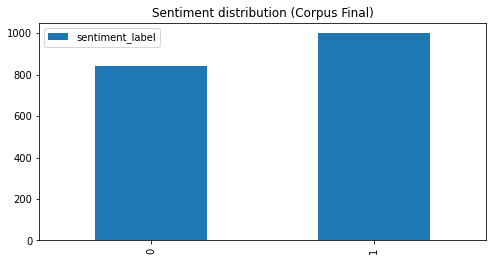

In [66]:
aux_df_ts = pd.DataFrame(test['sentiment_label'].value_counts(sort=False).sort_index())
aux_df_ts = aux_df_ts.plot(kind='bar', title='Sentiment distribution (Corpus Final)', figsize=(8, 4))

In [67]:
#contamos las reviews positivas y las negativas
print('Total de etiquetas negativas: ', len(test[test['sentiment_label']== 0]))
print('Total de etiquetas positivas: ',len(test[test['sentiment_label']== 1]))


Total de etiquetas negativas:  840
Total de etiquetas positivas:  999


####2.1.3. N-grams más frecuentes

In [68]:
bigrams_ts = ngrams(unique_word_ts, 2)
trigrams_ts = ngrams(unique_word_ts, 3)

In [69]:
bigrams_freq_ts = FreqDist(bigrams_ts)
trigrams_freq_ts = FreqDist(trigrams_ts)

In [70]:
bigrams_freq_ts.most_common(10)

[(('fishy', 'PizzaExpert'), 1),
 (('PizzaExpert', 'porm'), 1),
 (('porm', 'cove'), 1),
 (('cove', 'huge'), 1),
 (('huge', 'basics'), 1),
 (('basics', 'cuttlefish'), 1),
 (('cuttlefish', 'IHOP'), 1),
 (('IHOP', 'kinda'), 1),
 (('kinda', 'healthy'), 1),
 (('healthy', 'possible'), 1)]

In [71]:
trigrams_freq_ts.most_common(10)


[(('fishy', 'PizzaExpert', 'porm'), 1),
 (('PizzaExpert', 'porm', 'cove'), 1),
 (('porm', 'cove', 'huge'), 1),
 (('cove', 'huge', 'basics'), 1),
 (('huge', 'basics', 'cuttlefish'), 1),
 (('basics', 'cuttlefish', 'IHOP'), 1),
 (('cuttlefish', 'IHOP', 'kinda'), 1),
 (('IHOP', 'kinda', 'healthy'), 1),
 (('kinda', 'healthy', 'possible'), 1),
 (('healthy', 'possible', 'Shell'), 1)]

In [72]:
bg_freq_most_common = bigrams_freq_ts.most_common(10)
bgs_ = [str(bg[0]) for bg in bg_freq_most_common]
bgs_f_ = [bg[1] for bg in bg_freq_most_common]

tg_freq_most_common = trigrams_freq_ts.most_common(10)
tgs_ = [str(tg[0]) for tg in tg_freq_most_common]
tgs_f_ = [tg[1] for tg in tg_freq_most_common]

In [73]:
bgs_f_, bgs_ = zip(*sorted(zip(bgs_f_, bgs_)))
tgs_f_, tgs_ = zip(*sorted(zip(tgs_f_, tgs_)))

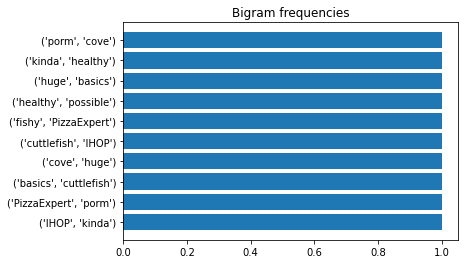

In [74]:
plt.barh(bgs_, bgs_f_)
plt.title('Bigram frequencies')
plt.show()

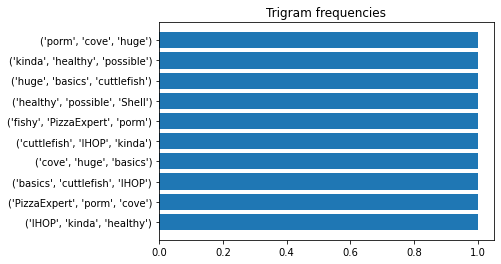

In [75]:
plt.barh(tgs_, tgs_f_)
plt.title('Trigram frequencies')
plt.show()

####2.1.4. Nube de palabras

In [76]:
#convertir mi lista de palabras en una cadena 
#" ".join(unique_word)

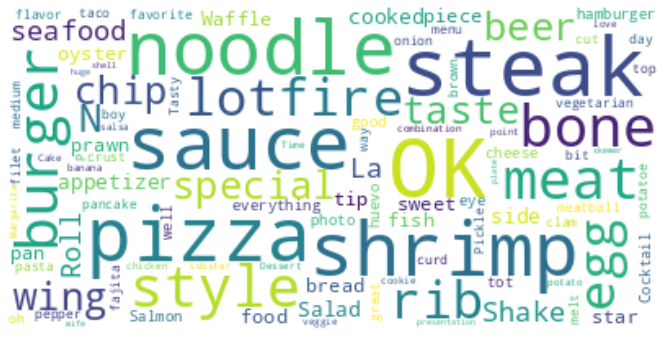

In [77]:
#representamos la nube de palabras
plot_word_cloud(unique_word_ts)

####2.1.5. palabras similares con word2vec

In [78]:
import multiprocessing

from gensim.models import Word2Vec

cores = multiprocessing.cpu_count() # Contamos el número de cores en el ordenador
print (cores)

#hiperparámetros de inicialización 
w2v_model_ts = Word2Vec(min_count=20,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)



2


In [79]:
sent = [row for row in train['words']]
w2v_model_ts.build_vocab(sent, progress_per=10000)

In [80]:
print('Vocabulario compuesto por {} palabras'.format(len(w2v_model_ts.wv.vocab)))

Vocabulario compuesto por 936 palabras


In [81]:
#entrenamos el modelo del w2v
w2v_model_ts.train(sent, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

(978955, 5017830)

In [82]:
#algunos resultados similares de sentimiento postivo
w2v_model_ts.wv.most_similar(positive=["fresh"])

[('super', 0.997713565826416),
 ('extremely', 0.9974285364151001),
 ('greasy', 0.9973089098930359),
 ('salty', 0.9971700310707092),
 ('soggy', 0.9971171021461487),
 ('.', 0.996841311454773),
 ('lots', 0.9967104196548462),
 ('heavy', 0.9967094659805298),
 ('ok.', 0.9966317415237427),
 ('breading', 0.9966139793395996)]

In [83]:
#algunos resultados similares de sentimiento postivo
w2v_model_ts.wv.most_similar(positive=["crispy"])

[('crisp', 0.9988695383071899),
 ('juicy', 0.9984238147735596),
 ('crunchy', 0.9980343580245972),
 ('breast', 0.9980155229568481),
 ('flavorful', 0.9977031946182251),
 ('bland', 0.997523307800293),
 ('red', 0.9974849224090576),
 ('tender', 0.997450053691864),
 ('dressing', 0.9973908066749573),
 ('dipping', 0.9969704151153564)]

In [84]:
#algunos resultados similares de sentimiento postivo
w2v_model_ts.wv.most_similar(positive=["chicken"])

[('and', 0.9952077865600586),
 ('slaw', 0.993332028388977),
 ('rice', 0.993133544921875),
 ('mac', 0.9930177927017212),
 ('cheese', 0.9923974275588989),
 ('okra', 0.9923347234725952),
 ('beans', 0.9921501874923706),
 ('shrimp', 0.9906993508338928),
 ('potato', 0.9904223680496216),
 ('fried', 0.9903756380081177)]

In [85]:
w2v_model_ts.wv.similarity('fresh', 'crispy')

0.9855259

In [86]:
w2v_model_ts.wv.similarity('chicken', 'fries')

0.9845092

In [87]:
w2v_model_ts.save('./w2v_model_ts.pkl')

In [88]:
# almacenamos las imagenes en nuestro drive
!cp w2v_model_ts.pkl /content/drive/MyDrive/NLP/w2v_model_ts.pkl


In [89]:
!ls -lah w2v_model_ts.pkl

-rw-r--r-- 1 root root 3.3M Mar 12 18:31 w2v_model_ts.pkl


In [90]:
#cargamos el modelo 
w2v_sg_ts = Word2Vec.load('./w2v_model_ts.pkl')

In [91]:
keys_ts = ['amazing','creamy','fries']

embedding_clusters_ts = []
word_clusters_ts = []
for word in keys_ts:
    embeddings = []
    words = []
    for similar_word, _ in w2v_sg.wv.most_similar(word, topn=10):
        words.append(similar_word)
        embeddings.append(w2v_sg.wv[similar_word])
    embedding_clusters_ts.append(embeddings)
    word_clusters_ts.append(words)

In [92]:
print(word_clusters_ts)

[['fantastic', 'awesome', 'signature', 'Loved', 'Love', 'solid', 'Both', 'standard', 'Ribs', 'Food'], ['dressing', 'red', 'dipping', 'coleslaw', 'pepper', 'bean', 'moist', 'flavorful', 'spicy', 'crispy'], ['sweet', 'potato', 'okra', 'sauce', 'sausage', 'crisp', 'roasted', 'slaw', 'crispy', 'greens']]


In [93]:
#reducimos la dimensionalidad para representarlo en 2D
tsne_model_2d_ts = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)

embed_clusters_ts = np.array(embedding_clusters_ts)
n, m, k = embed_clusters_ts.shape

embeddings_2d_ts = np.array(tsne_model_2d.fit_transform(embed_clusters_ts.reshape(n * m, k))).reshape(n, m, 2)

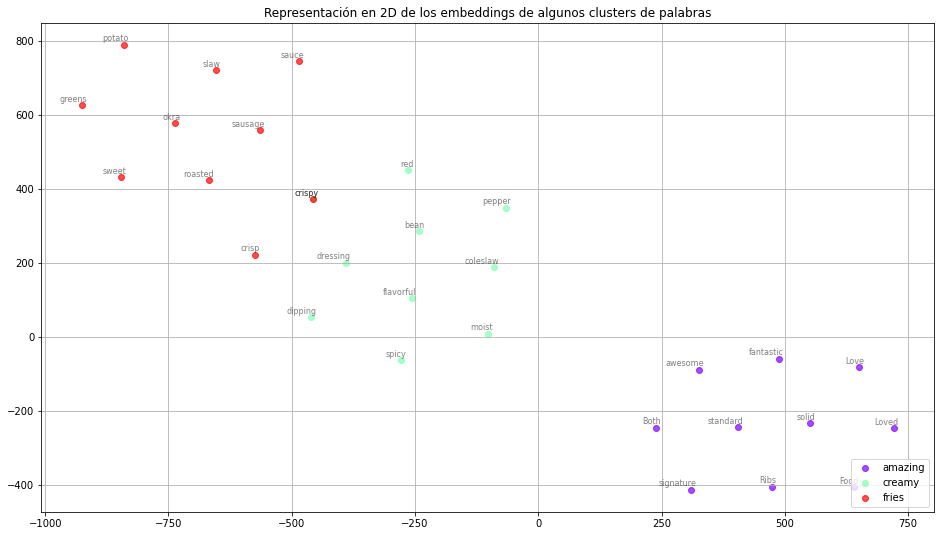

In [94]:
#Representamos los clusters

tsne_plot_similar_words(keys_ts, embeddings_2d_ts, word_clusters_ts)

## 3. Conclusiones del análisis exploratorio


Nos encontramos con un conjunto de palabras bastante sucío con numerosas stopwords, simbolos y signos de puntuación.


#### Guardamos todo en gDrive

In [95]:
#train.to_csv('./train.csv', sep=';', decimal='.', index=False)
#test.to_csv('./test.csv', sep=';', decimal='.', index=False)

In [96]:
# guardamos los dfs

train.to_csv('train.csv', encoding='utf-8', index=False)
test.to_csv('test.csv', encoding='utf-8', index=False)


In [97]:
#compruebo que los he guardado en mi disco de colab
!ls -lah   

total 9.4M
drwxr-xr-x 1 root root 4.0K Mar 12 13:35 .
drwxr-xr-x 1 root root 4.0K Mar 12 09:33 ..
drwxr-xr-x 4 root root 4.0K Mar  9 18:57 .config
drwx------ 5 root root 4.0K Mar 12 13:35 drive
drwxr-xr-x 1 root root 4.0K Mar  9 18:58 sample_data
-rw-r--r-- 1 root root 731K Mar 12 18:31 test.csv
-rw-r--r-- 1 root root 2.2M Mar 12 18:31 train.csv
-rw-r--r-- 1 root root 3.3M Mar 12 18:31 w2v_model.pkl
-rw-r--r-- 1 root root 3.3M Mar 12 18:31 w2v_model_ts.pkl


In [98]:
# lo movemos a nuestro en nuestro google drive
!cp /content/train.csv /content/drive/MyDrive/NLP/train.csv
!cp /content/test.csv /content/drive/MyDrive/NLP/test.csv